In [11]:
from datetime import datetime
import fsspec
from http.cookiejar import CookieJar
from netrc import netrc
import numpy as np
from os.path import basename, isfile, isdir, join, expanduser
from platform import system
from urllib import request
import xarray as xr
import time
import requests
import matplotlib.pyplot as plt
import cartopy
import dask

# Subroutines

In [2]:
# # do we need that?
# def setup_earthdata_login_auth(url: str='urs.earthdata.nasa.gov'):
#     # look for the netrc file and use the login/password
#     try:
#         username, _, password = netrc(file=_netrc).authenticators(url)

#     # if the file is not found, prompt the user for the login/password
#     except (FileNotFoundError, TypeError):
#         print('Please provide Earthdata Login credentials for access.')
#         username, password = input('Username: '), getpass('Password: ')
    
#     manager = request.HTTPPasswordMgrWithDefaultRealm()
#     manager.add_password(None, url, username, password)
#     auth = request.HTTPBasicAuthHandler(manager)
#     jar = CookieJar()
#     processor = request.HTTPCookieProcessor(jar)
#     opener = request.build_opener(auth, processor)
#     request.install_opener(opener)

# my thing:
# !cat ~/.netrc | grep 'urs.earthdata.nasa.gov' | wc -l

In [3]:
def init_cartopy_global(projection, box, latstep, lonstep, land, zorder=4,**karg):
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature

    # ax = plt.axes(projection=projection)
    ax=plt.subplot(1,1,1,projection=projection)
    if land==True:
        land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor=cfeature.COLORS['land'])
        ax.add_feature(land_10m, zorder=zorder)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=zorder,edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS, zorder=zorder)
    ax.coastlines('10m')
    # ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(np.floor(box[0]),np.floor(box[1]),lonstep), crs=projection)
    ax.set_yticks(np.arange(np.floor(box[2]),np.floor(box[3]),latstep), crs=projection)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='both', which='major', labelsize=16)
    gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=2, alpha=0.15, color='gray')
    if 'pacific' in karg:
        gl.xlocator = mticker.FixedLocator(np.arange(box[1],box[0]+360,lonstep))
    else:
        gl.xlocator = mticker.FixedLocator(np.arange(np.floor(box[0]),np.floor(box[1])+lonstep,lonstep))
    gl.ylocator = mticker.FixedLocator(np.arange(np.floor(box[2]),np.floor(box[3])+latstep,latstep))
    return ax, gl

In [4]:
def init_S3FileSystem():
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem
    """
  
    import requests,s3fs
    credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    return s3, credentials


In [5]:
def update_credential(credentials, force=False):
    now=np.datetime64(datetime.now())
    
    # expiration time of current credential
    exp=np.datetime64(credentials['expiration'][:-6])
    # current time
    
    # how much time is left [seconds]
    td_sec = np.double(exp-now)/1e6

    # if < 1800 seconds left before credential expires, renew it
    if (td_sec < 1800) or (force==True):
        print(f'... updating credentials, {td_sec}s remaining')
        s3, credentials = init_S3FileSystem()
        exp=np.datetime64(credentials['expiration'][:-6])
        td_sec = np.double(exp-now)/1e6
        print(f'... after credential update, {td_sec}s remaining')
    else:
        print(f'... not updating credentials, {td_sec}s remaining')
        
    return credentials

In [6]:
# do we need that?
# _netrc = join(expanduser('~'), "_netrc" if system()=="Windows" else ".netrc")
# print(_netrc, type(_netrc))

# setup_earthdata_login_auth()

In [7]:
s3, credentials = init_S3FileSystem()

In [1]:
# update_credential(credentials, force=False)

In [9]:
# loads a dataset from the 'kerchunk' json where the
# netcdf files are stored on s3
def load_dataset_from_json_s3(json_file_path, credentials, time_chunk=20):
    
    fs = fsspec.filesystem(
        "reference", 
        fo=json_file_path, 
        remote_protocol="s3", 
        remote_options={'anon':False, 
                        'key':credentials['accessKeyId'], 
                        'secret':credentials['secretAccessKey'],
                        'token':credentials['sessionToken']},
        skip_instance_cache=True
    )
    m = fs.get_mapper("")
    if time_chunk > 0:
        ds = xr.open_dataset(m, engine='zarr', consolidated=False, chunks={'time':time_chunk})
    else:
        ds = xr.open_dataset(m, engine='zarr', consolidated=False)
    
    ds.close()
    
    return ds

# Load OSCAR kerchunk files

In [12]:
start_time = time.time()
json_file_path = '/home/jpluser/efs-mount-point/sevfour/oscar/kerchunk/MZZ_INTERIM_V2.0/OSCAR_L4_OC_INTERIM_V2.0.json'
oscar_interim = load_dataset_from_json_s3(json_file_path, credentials)
print(time.time() - start_time)

0.6695704460144043


In [13]:
json_file_path = '/home/jpluser/efs-mount-point/sevfour/oscar/kerchunk/MZZ_FINAL_V2.0/OSCAR_L4_OC_FINAL_V2.0.json'
oscar_final = load_dataset_from_json_s3(json_file_path, credentials)

In [14]:
u=xr.concat([oscar_final.u, oscar_interim.u.sel(time=slice(oscar_final.time[-1].values,None))], dim="time")
v=xr.concat([oscar_final.v, oscar_interim.v.sel(time=slice(oscar_final.time[-1].values,None))], dim="time")
speed=np.sqrt(u**2+v**2)

In [15]:
u

<xarray.DataArray 'u' (time: 11304, longitude: 1440, latitude: 719)> Size: 94GB
dask.array<concatenate, shape=(11304, 1440, 719), dtype=float64, chunksize=(20, 720, 360), chunktype=numpy.ndarray>
Coordinates:
    lat      (latitude) float64 6kB -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    lon      (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time     (time) object 90kB 1993-01-01 00:00:00 ... 2024-08-31 00:00:00
Dimensions without coordinates: longitude, latitude
Attributes:
    comment:                Velocities are an average over the top 30m of the...
    coverage_content_type:  modelResult
    depth:                  15m
    long_name:              zonal total surface current
    source:                 SSH source: CMEMS SSALTO/DUACS SEALEVEL_GLO_PHY_L...
    standard_name:          eastward_sea_water_velocity
    units:                  m s-1
    valid_max:              3.0
    valid_min:              -3.0

In [16]:
oscar_final.u

<xarray.DataArray 'u' (time: 10803, longitude: 1440, latitude: 719)> Size: 89GB
dask.array<open_dataset-u, shape=(10803, 1440, 719), dtype=float64, chunksize=(20, 720, 360), chunktype=numpy.ndarray>
Coordinates:
    lat      (latitude) float64 6kB dask.array<chunksize=(719,), meta=np.ndarray>
    lon      (longitude) float64 12kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * time     (time) object 86kB 1993-01-01 00:00:00 ... 2022-08-04 00:00:00
Dimensions without coordinates: longitude, latitude
Attributes:
    comment:                Velocities are an average over the top 30m of the...
    coverage_content_type:  modelResult
    depth:                  15m
    long_name:              zonal total surface current
    source:                 SSH source: CMEMS SSALTO/DUACS SEALEVEL_GLO_PHY_L...
    standard_name:          eastward_sea_water_velocity
    units:                  m s-1
    valid_max:              3.0
    valid_min:              -3.0

# Dask

In [17]:
from dask.distributed import Client, LocalCluster
client = Client("tcp://100.104.70.36:8786")
client

<Client: 'tcp://100.104.70.36:8786' processes=12 threads=12, memory=46.48 GiB>

Task exception was never retrieved
future: <Task finished name='Task-180' coro=<Client._gather.<locals>.wait() done, defined at /home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py:2395> exception=AllExit()>
Traceback (most recent call last):
  File "/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py", line 2404, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-134' coro=<Client._gather.<locals>.wait() done, defined at /home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py:2395> exception=AllExit()>
Traceback (most recent call last):
  File "/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/distributed/client.py", line 2404, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-90' coro=<Client._gather.<locals>.wait() do

# Compute Trend

In [18]:
# Not necessary to do pixel by pixel
# @dask.delayed
# def trend_ij(i,j):
#     tmp = speed[:,i,j].polyfit(dim = "time", skipna=True, deg = 1)
#     return tmp.polyfit_coefficients.sel(degree=1).values*86400000000000*365*10

# # lats to process
# jjs = range(0,len(speed.latitude))
# # lons to process
# iis = range(0,len(speed.longitude))

# result = []
# for i in iis:
#     for j in jjs:
#         result.append(trend_ij(i,j))
# trend = dask.compute(result)[0]

In [20]:
start_time = time.time()
u_c = u.chunk(chunks={"time":365, "latitude":100, "longitude":100}) #need to chunk in space, otherwise memory issue
trendu = u_c.polyfit(dim = "time", skipna=True, deg = 1)
trendu = trendu.compute()
print(time.time() - start_time)

847.9071841239929


In [ ]:
v_c = v.chunk(chunks={"time":365, "latitude":100, "longitude":100}) #need to chunk in space, otherwise memory issue
trendv = v_c.polyfit(dim = "time", skipna=True, deg = 1)
trendv = trendv.compute()

In [ ]:
u

In [22]:
trendu

<xarray.Dataset> Size: 17MB
Dimensions:               (longitude: 1440, latitude: 719, degree: 2)
Coordinates:
  * longitude             (longitude) int64 12kB 0 1 2 3 ... 1436 1437 1438 1439
  * latitude              (latitude) int64 6kB 0 1 2 3 4 ... 714 715 716 717 718
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, longitude, latitude) float64 17MB nan ... nan

# Figures

/tmp/ipykernel_431144/771801021.py:20: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')


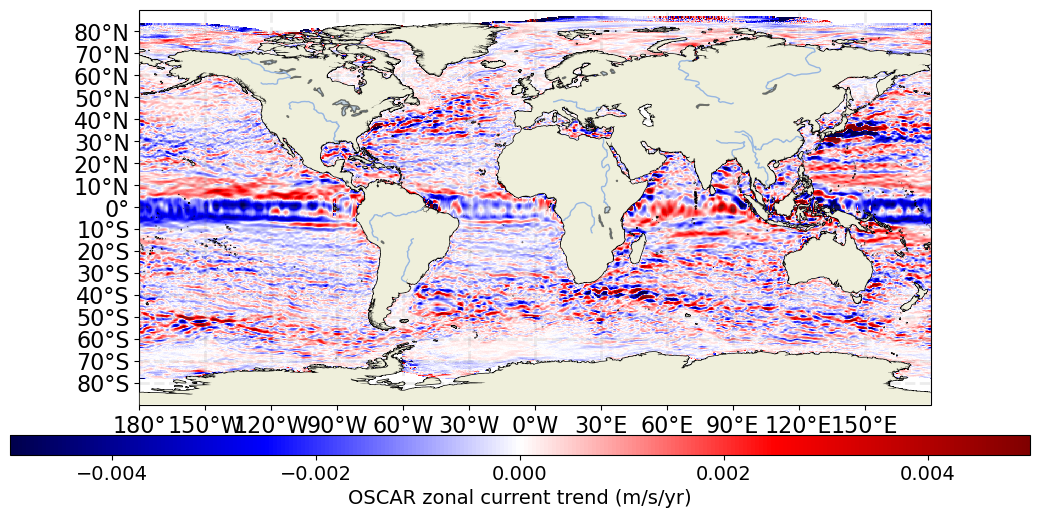

In [30]:
lonmin = -180
lonmax = 180
latmin = -90
latmax = 90
box = [lonmin, lonmax, latmin, latmax]
latstep = 10
lonstep=30
land=True

fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.seismic
palette.set_bad('w',1.0)
pp = plt.pcolor(u.lon,u.lat,trendu.polyfit_coefficients[0,:,:].transpose().values*86400000000000*365,cmap=palette,vmin=-0.005,vmax=0.005,transform=data_proj) 
# pp = plt.pcolor(u.lon,u.lat,trendu.polyfit_coefficients[0,:,:].transpose().values,cmap=palette,vmin=-1e-19,vmax=1e-19,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('OSCAR zonal current trend (m/s/yr)',fontsize=14)
h.ax.tick_params(labelsize=14)

/tmp/ipykernel_431144/1974732516.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')


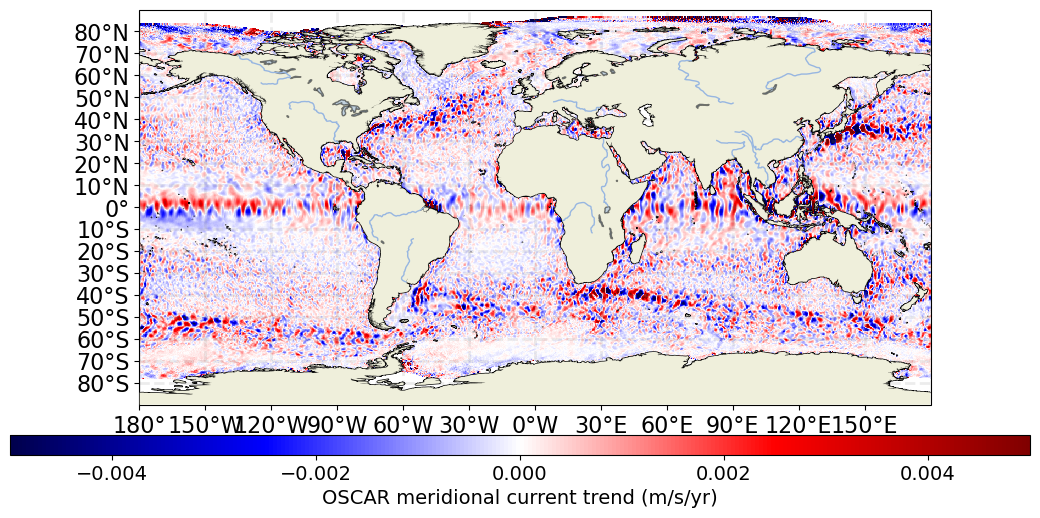

In [27]:
fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.seismic
palette.set_bad('w',1.0)
pp = plt.pcolor(u.lon,u.lat,trendv.polyfit_coefficients[0,:,:].transpose().values*86400000000000*365,cmap=palette,vmin=-0.005,vmax=0.005,transform=data_proj) 
# pp = plt.pcolor(u.lon,u.lat,trendv.polyfit_coefficients[0,:,:].transpose().values,cmap=palette,vmin=-1e-19,vmax=1e-19,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('OSCAR meridional current trend (m/s/yr)',fontsize=14)
h.ax.tick_params(labelsize=14)